Proyecto mineria de datos:
### Minería de Datos para Equidad Educativa en Comunas Vulnerables
##### grupo: 14

##### Integrantes: 
1) Ignacio Gabler  
2) Cristobla Merino


### 1) Preprocesamiento de Datos

In [59]:
import zipfile
import os
import pathlib

# Obtener la ruta del directorio actual
ruta_actual = pathlib.Path().absolute()

# Ruta relativa al archivo zip
ruta_zip = os.path.join(ruta_actual, "archive.zip")
# Carpeta destino
carpeta_destino = os.path.join(ruta_actual, "datos")

# Descomprimir
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)



print(f"archivos extraidos en: {carpeta_destino}")

archivos extraidos en: c:\Users\ignac\OneDrive\Desktop\md14_proyecto\datos


In [ ]:
#vamos a utilizarel archivo Expanded_data_with_more_features.csv porque es 
# el que contiene más características que nos interesa
import pandas as pd	

df = pd.read_csv("datos/Expanded_data_with_more_features.csv")

print(df.head())
print(df.info())
print(df.isnull().sum())


   Unnamed: 0  Gender EthnicGroup          ParentEduc     LunchType TestPrep  \
0           0  female         NaN   bachelor's degree      standard     none   
1           1  female     group C        some college      standard      NaN   
2           2  female     group B     master's degree      standard     none   
3           3    male     group A  associate's degree  free/reduced     none   
4           4    male     group C        some college      standard     none   

  ParentMaritalStatus PracticeSport IsFirstChild  NrSiblings TransportMeans  \
0             married     regularly          yes         3.0     school_bus   
1             married     sometimes          yes         0.0            NaN   
2              single     sometimes          yes         4.0     school_bus   
3             married         never           no         1.0            NaN   
4             married     sometimes          yes         0.0     school_bus   

  WklyStudyHours  MathScore  ReadingScore  W

In [ ]:
df_copy = df.copy()

# eliminar null
df_copy = df_copy.dropna()

print(f"Filas antes de eliminar nulos: {len(df)}")
print(f"Filas después de eliminar nulos: {len(df_copy)}")

Filas antes de eliminar nulos: 30641
Filas después de eliminar nulos: 19243


Eliminamos las filas con valores nulos, pero no borramos niguna columna (excepto la primera de id) para no perder información relevante. De esta manera obtener los factores y habitos que afectan en el rendimiento estudiantil de los alumnos de las comunas vulnerables de la región metropolitana.





In [62]:
#dropear unammed
df_copy = df_copy.drop(columns=['Unnamed: 0'], errors='ignore')

### 2) Encoding variables categoricas

#### label encoding

In [63]:

df_copy['Gender'] = df_copy['Gender'].map({'female': 0, 'male': 1})

# yes = 1  , no = 0
df_copy['IsFirstChild'] = df_copy['IsFirstChild'].map({'yes': 1, 'no': 0})



In [64]:

df_copy['TestPrep'] = df_copy['TestPrep'].map({'none': 0, 'completed': 1})
df_copy['PracticeSport'] = df_copy['PracticeSport'].map({'never': 0, 'sometimes': 1, 'regularly': 2})


#### One hot encoding

In [65]:
df_copy = pd.get_dummies(df_copy, columns=['EthnicGroup', 'ParentEduc', 'LunchType', 'ParentMaritalStatus', 'TransportMeans', 'WklyStudyHours'], drop_first=True)


In [66]:
df_copy = df_copy.astype(int)

print(df_copy.head(1))

# quiero ver todas los nombres de columnas
print("Nombres de columnas:")
print(df_copy.columns.tolist())

   Gender  TestPrep  PracticeSport  IsFirstChild  NrSiblings  MathScore  \
2       0         0              1             1           4         87   

   ReadingScore  WritingScore  EthnicGroup_group B  EthnicGroup_group C  ...  \
2            93            91                    1                    0  ...   

   ParentEduc_master's degree  ParentEduc_some college  \
2                           1                        0   

   ParentEduc_some high school  LunchType_standard  \
2                            0                   1   

   ParentMaritalStatus_married  ParentMaritalStatus_single  \
2                            0                           1   

   ParentMaritalStatus_widowed  TransportMeans_school_bus  WklyStudyHours_< 5  \
2                            0                          1                   1   

   WklyStudyHours_> 10  
2                    0  

[1 rows x 24 columns]
Nombres de columnas:
['Gender', 'TestPrep', 'PracticeSport', 'IsFirstChild', 'NrSiblings', 'MathScore

#### Variables Objetivo

In [ ]:
from sklearn.preprocessing import StandardScaler


y = df_copy[['MathScore', 'ReadingScore', 'WritingScore']]
X = df_copy.drop(columns=['MathScore', 'ReadingScore', 'WritingScore'])
 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [78]:
y_math = y['MathScore']
y_reading = y['ReadingScore']
y_writing = y['WritingScore']
scores = [y_math, y_reading, y_writing]

#### PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada:", pca.explained_variance_ratio_.sum())


Varianza explicada por cada componente: [0.07890278 0.06768048]
Varianza total explicada: 0.14658325976830522


Es esperable una variaza baja cuando las variables son binarias o categoricas.

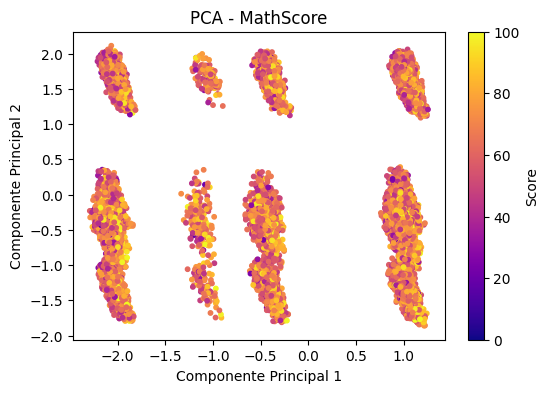

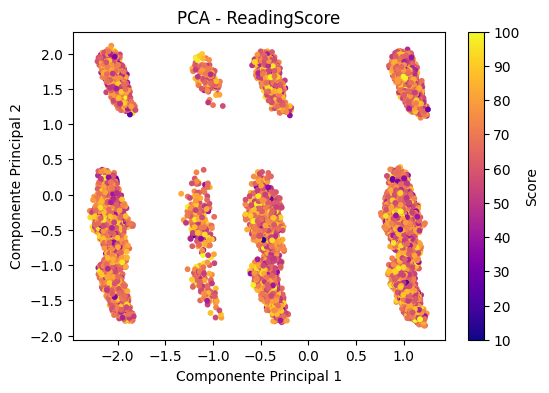

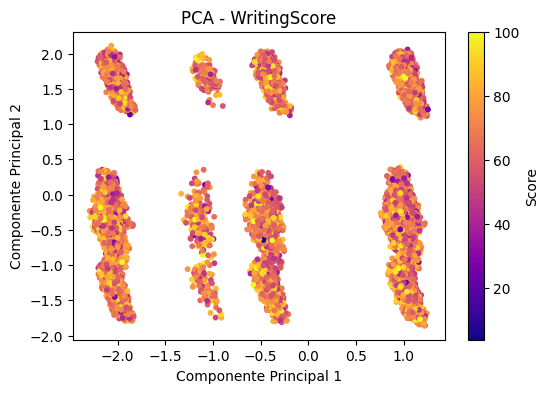

In [84]:
for score in scores:
    plt.figure(figsize=(6, 4))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=score, cmap="plasma", s=10)
    plt.colorbar(label='Score')
    plt.title(f'PCA - {score.name}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()


#### t-SNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=20, learning_rate=500)
X_tsne = tsne.fit_transform(X_scaled)


1) n_components = 2 
para reducir a 2 dimensiones


2) perplexity = 20
Buscamos pequeños grupos que resalten sus resultados por conjuntos especificos de variables, por lo que esperamos grupos pequeños y bien definidos de alrededor de 20 puntos. Asi podemos observar si hay agrupaciones de estudiantes con caracteristicas similares y no sobre ajustamos el modelo.


3) learning_rate = 500
Buscamos que el modelo converja rapidamente en primera instancias, una vez que encontremos patrones claros, podemos ajustar el learning rate para mejorar la convergencia y la calidad de los grupos.



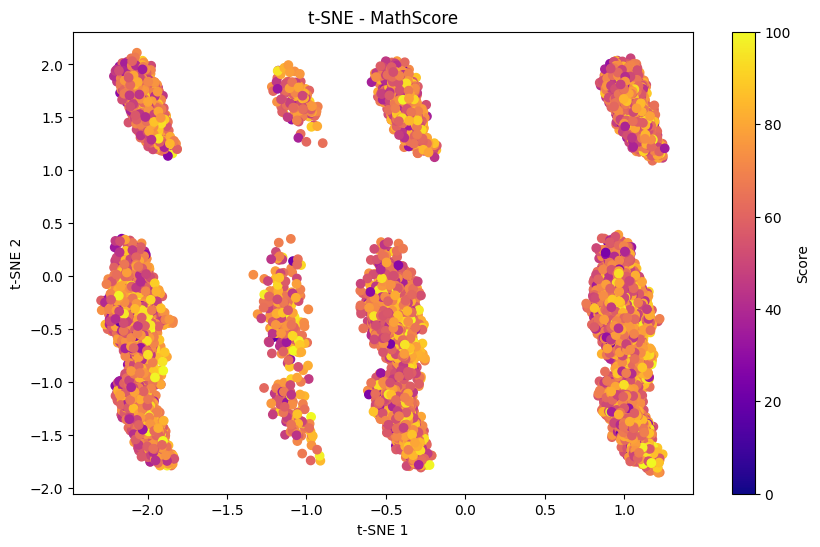

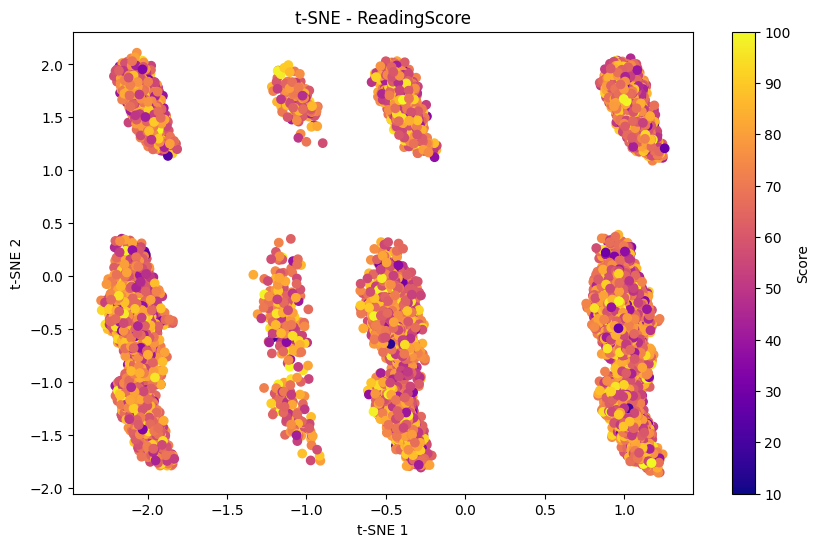

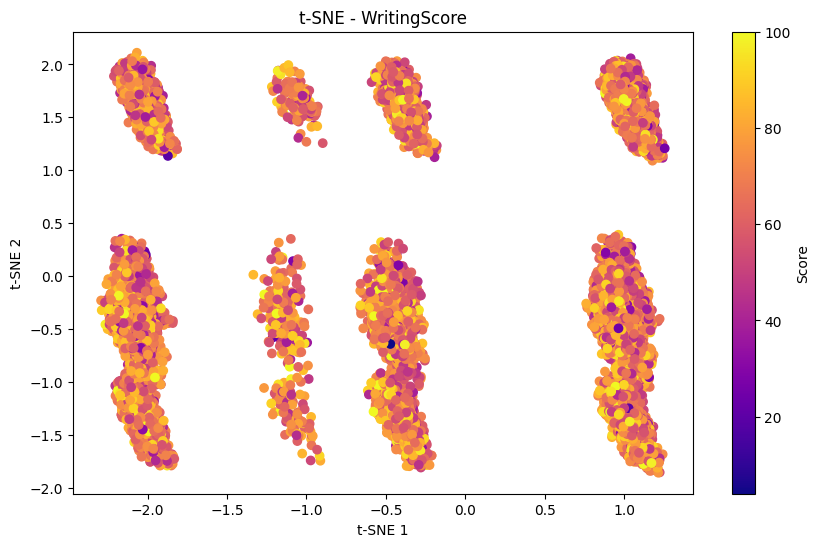

In [93]:
for score in scores:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=score, cmap='plasma')
    plt.colorbar(label='Score')
    plt.title(f't-SNE - {score.name}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()




#### UMAP

In [95]:
import umap
import matplotlib.pyplot as plt


umap_model = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1)
X_umap = umap_model.fit_transform(X_scaled)


c:\Users\ignac\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n_components	2	Para visualización 2D
n_neighbors	20	Grupos esperados de estudiantes similares
min_dist	0.1	Mantiene cierta separación entre puntos, útil para ver clústeres


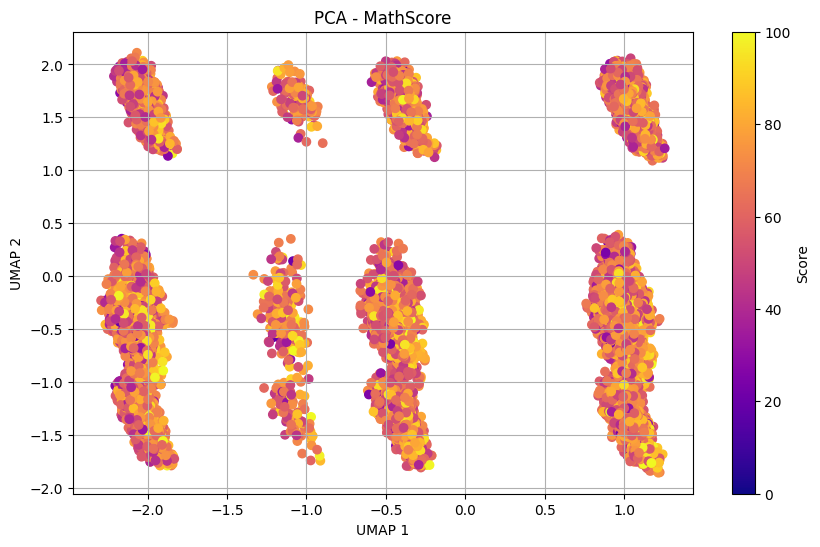

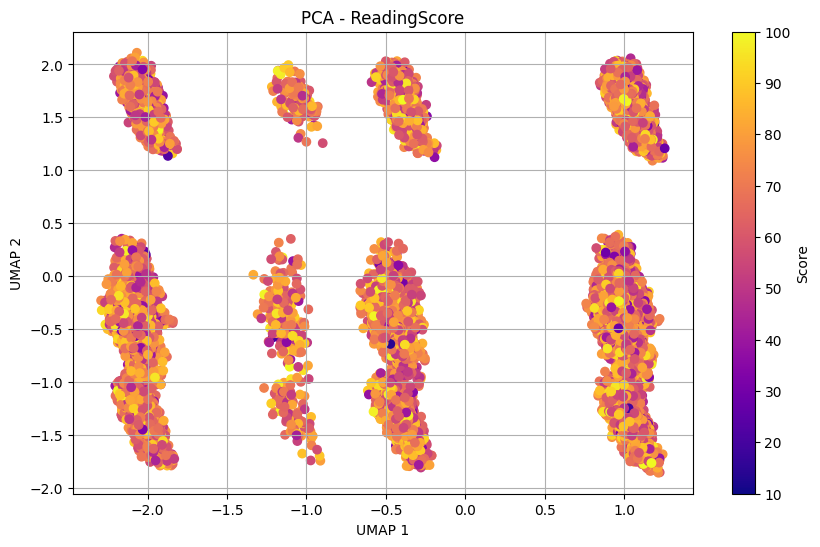

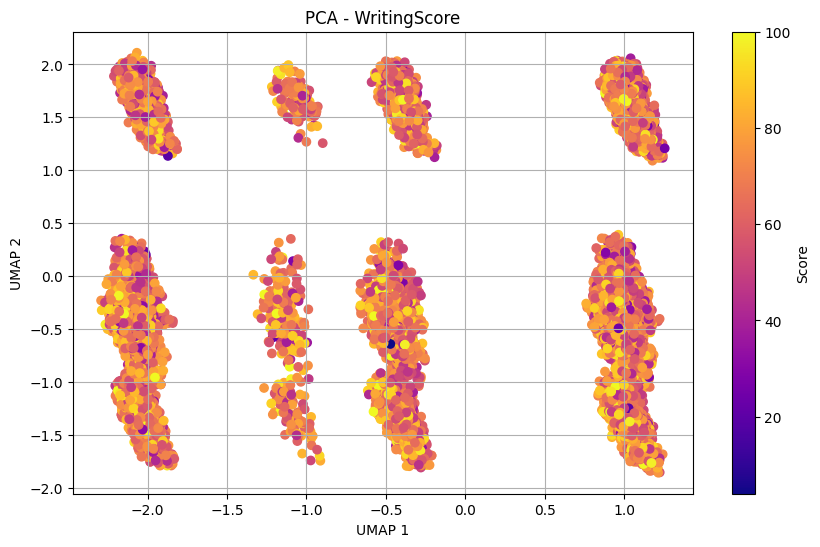

In [96]:
for score in scores:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=score, cmap='plasma')
    plt.colorbar(label='Score')
    plt.title(f'PCA - {score.name}')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.grid(True)
    plt.show()




### Clustering

#### KMeans

In [117]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8)
labels_kmeans = kmeans.fit_predict(X_umap)

Encontramos que con 8 clusters se logra una buena separación de los datos, permitiendo identificar grupos de estudiantes con características similares. 

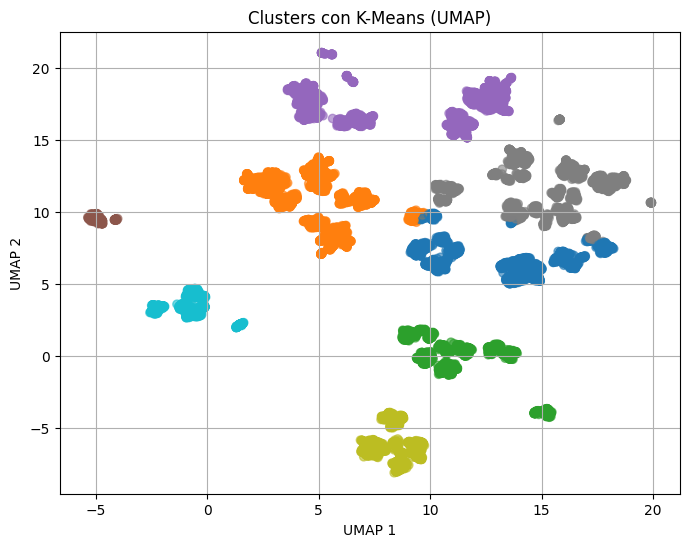

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_kmeans, cmap='tab10', alpha=0.6)
plt.title('Clusters con K-Means (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


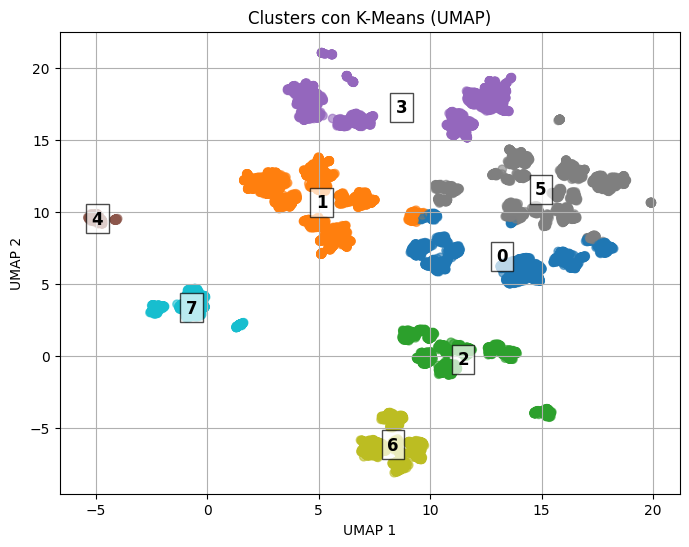

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_kmeans, cmap='tab10', alpha=0.6)

# Agregar números al centro de cada cluster
for cluster_label in np.unique(labels_kmeans):
    # Calcular el centro del cluster
    idx = labels_kmeans == cluster_label
    x_mean = X_umap[idx, 0].mean()
    y_mean = X_umap[idx, 1].mean()
    # Mostrar número del cluster en el centro
    plt.text(x_mean, y_mean, str(cluster_label), fontsize=12, fontweight='bold', color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


plt.title('Clusters con K-Means (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

In [ ]:
kmeans_scores = df_copy.groupby('KMeans_Cluster')[['MathScore', 'ReadingScore', 'WritingScore']].mean()
print("Promedios por grupo (K-Means):")

kmeans_scores['AverageScore'] = kmeans_scores.mean(axis=1)

print(kmeans_scores)


Promedios por grupo (K-Means):
                MathScore  ReadingScore  WritingScore  AverageScore
KMeans_Cluster                                                     
0               66.031281     69.227621     68.680532     67.979811
1               65.572135     69.167539     68.556719     67.765464
2               74.763732     73.871163     72.176494     73.603796
3               62.273532     65.653657     63.920302     63.949164
4               68.083784     70.662162     69.651351     69.465766
5               62.696540     66.284119     64.719150     64.566603
6               69.335413     72.900156     73.305252     71.846941
7               72.263158     75.879481     76.368421     74.837020


#### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=50)
labels_dbscan = dbscan.fit_predict(X_umap)



Al menos 50 estudiantes deben tenr características similares para formar un grupo.


#### REVISAR

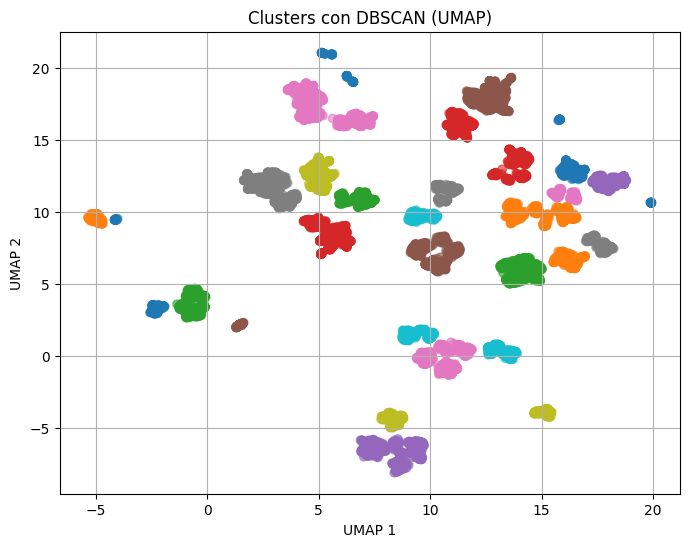

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_dbscan, cmap='tab10', alpha=0.6)
plt.title('Clusters con DBSCAN (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


In [ ]:
# Agregar etiquetas al DataFrame # REVISAR
df_copy['KMeans_Cluster'] = labels_kmeans
df_copy['DBSCAN_Cluster'] = labels_dbscan


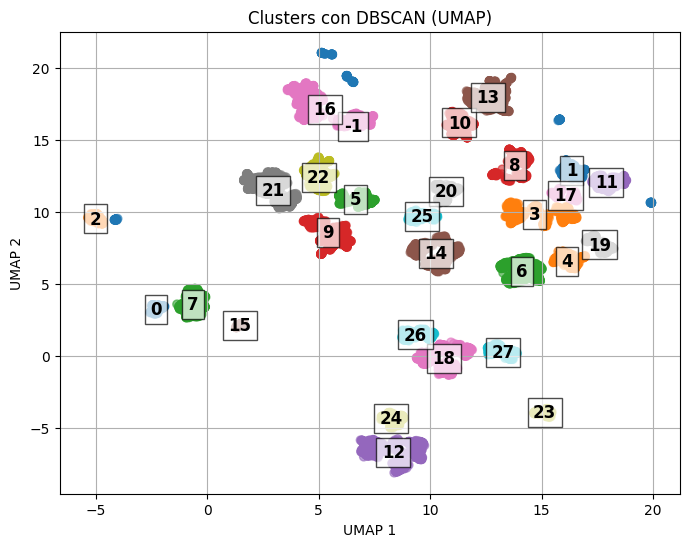

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_dbscan, cmap='tab10', alpha=0.6)

# Etiquetas numéricas sobre cada grupo
for cluster_label in np.unique(labels_dbscan):
    idx = labels_dbscan == cluster_label
    x_mean = X_umap[idx, 0].mean()
    y_mean = X_umap[idx, 1].mean()
    plt.text(x_mean, y_mean, str(cluster_label), fontsize=12, fontweight='bold',
             color='black', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


plt.title('Clusters con DBSCAN (UMAP)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


In [ ]:
dbscan_scores = df_copy.groupby('DBSCAN_Cluster')[['MathScore', 'ReadingScore', 'WritingScore']].mean()

# Agregar columna con el promedio total
dbscan_scores['AverageScore'] = dbscan_scores.mean(axis=1)
print("Promedios por grupo (DBSCAN):")
print(dbscan_scores)


Promedios por grupo (DBSCAN):
                MathScore  ReadingScore  WritingScore  AverageScore
DBSCAN_Cluster                                                     
-1              69.253521     71.957746     71.042254     70.751174
 0              68.635379     72.787004     72.610108     71.344164
 1              64.520971     68.295806     67.156733     66.657837
 2              67.538690     69.961310     68.750000     68.750000
 3              62.643810     66.332381     64.431429     64.469206
 4              65.672209     68.280285     67.266033     67.072842
 5              68.673575     71.571675     72.198618     70.814623
 6              68.595949     71.009595     70.989339     70.198294
 7              71.663953     75.855814     76.572093     74.697287
 8              59.580774     63.734312     61.491322     61.602136
 9              66.035996     69.879640     68.497188     68.137608
 10             65.029654     67.304778     66.924217     66.419550
 11             63

In [135]:
cluster_15 = df_copy[df_copy['DBSCAN_Cluster'] == 15]
cluster_15.describe()
cluster_15.mean(numeric_only=True)  # Muestra el promedio de columnas 0/1, útil para saber % del grupo


Gender                           0.477011
TestPrep                         0.298851
PracticeSport                    1.195402
IsFirstChild                     0.660920
NrSiblings                       2.275862
MathScore                       81.000000
ReadingScore                    80.919540
WritingScore                    81.344828
EthnicGroup_group B              0.000000
EthnicGroup_group C              0.000000
EthnicGroup_group D              0.000000
EthnicGroup_group E              1.000000
ParentEduc_bachelor's degree     0.000000
ParentEduc_high school           0.000000
ParentEduc_master's degree       1.000000
ParentEduc_some college          0.000000
ParentEduc_some high school      0.000000
LunchType_standard               0.603448
ParentMaritalStatus_married      0.534483
ParentMaritalStatus_single       0.247126
ParentMaritalStatus_widowed      0.000000
TransportMeans_school_bus        0.603448
WklyStudyHours_< 5               0.344828
WklyStudyHours_> 10              0